# Практическая работа №5. Классификация

## Цели:
- знакомство с теоретическими основами задачи классификации объектов;
- формирование навыков решения задачи бинарной классификации с помощью языка программирования Python.
## Задачи:
1. предварительная обработка исходных данных;
2. обучение базовых моделей классификации;
3. подбор оптимальных параметров моделей классификации;
4. оценка качества построенных моделей на тестовой выборке.
## Вариант 1. Исходные данные:
<a href="https://www.kaggle.com/c/mso-titanic/overview">Прогнозирование выживания на титанике</a>

## (#1) Импорты

In [2]:
# a b c d e f g h i j k l m n o p q r s t u v w x y z
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing, model_selection, metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## (#2) Загрузка данных

In [3]:
train_df = pd.read_csv("mso-titanic/train.csv")
y_train = train_df["Survived"].values
test_df = pd.read_csv("mso-titanic/test.csv")
train_len = len(train_df)
combined_df = pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)

test_copy = test_df.copy()

In [4]:
def create_submission(y_pred, algorithm_name):
    tc = test_copy.copy()
    tc['Survived'] = y_pred
    tc.set_index('PassengerId',inplace=True)
    tc[['Survived']].to_csv(f"results//{algorithm_name}.csv")

## (#3) Обзор признаков
- PassengerId - уникальный идентификатор записи
- Survived - целевая переменная, которую необходимо предсказывать. Два класса:
    - 0 - пассажир не выжил;
    - 1 - пассажир выжил.
- Pclass - класс пассажира на корабле, всего их три:
    - 1 - первый;
    - 2 - второй;
    - 3 - третий.
- Name - имя пассажира
- Sex - пол
- Age - возраст
- SibSp - количество (братьев/сестер + супругов) на борту
- Parch - количество (родителей + детей) на борту
- Ticket - номер билета
- Fare - плата за проезд
- Cabin - номер каюты пассажира
- Embarked - порт, в котором пассажир сел на борт, всего их три:
    - C - Шербур (Cherbourg);
    - Q - Куинстаун (Queenstown);
    - S - Саутгепмтон (Southampton).

In [5]:
num_cols = ['Age', 'SibSp', 'Parch', "Fare"]
print(f"Численные признаки: {num_cols}")
cat_cols = ['Pclass', 'Sex', 'Embarked']
print(f"Категориальные признаки: {cat_cols}")
# Cabin и Name тоже могут пригодиться
combined_df.sample(3)

Численные признаки: ['Age', 'SibSp', 'Parch', 'Fare']
Категориальные признаки: ['Pclass', 'Sex', 'Embarked']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
668,708,NaN,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,PC 17476,26.2875,E24,S
659,267,NaN,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S
174,444,1.0,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S


## (#4) Визуализация

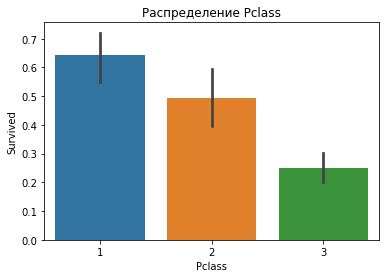

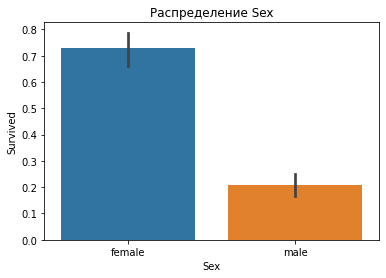

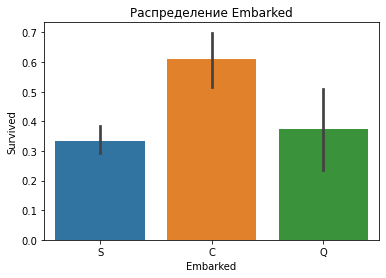

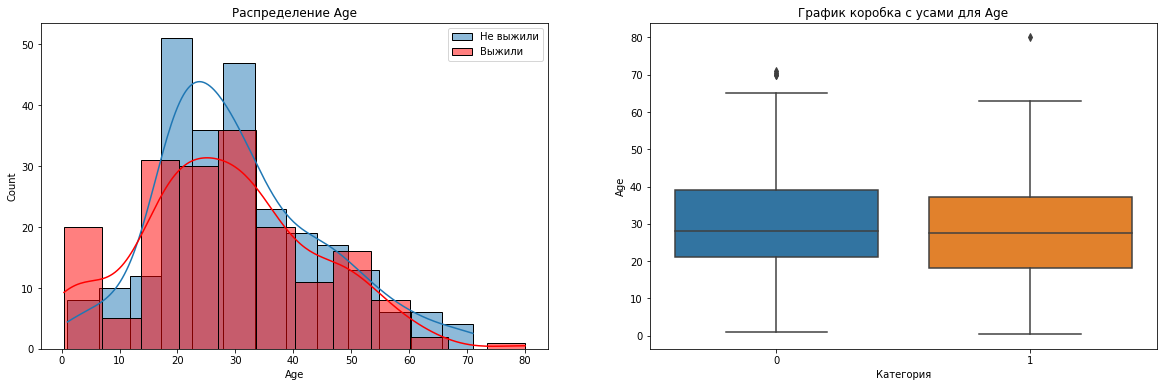

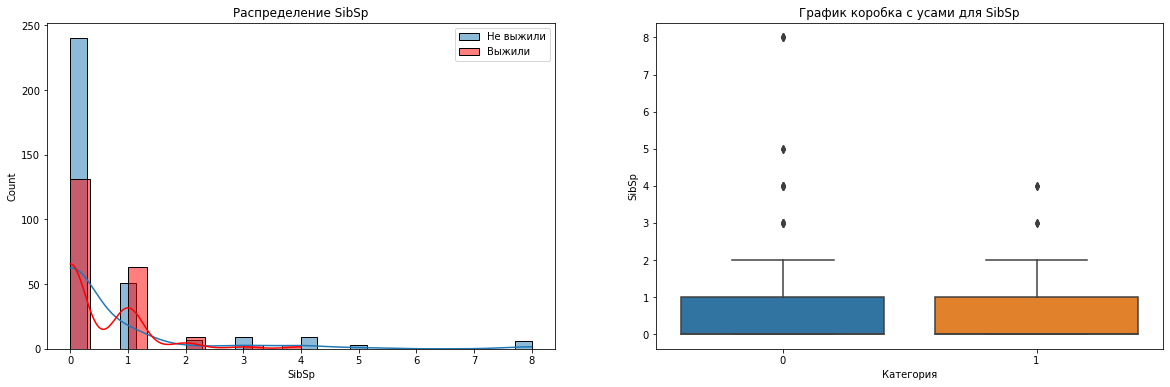

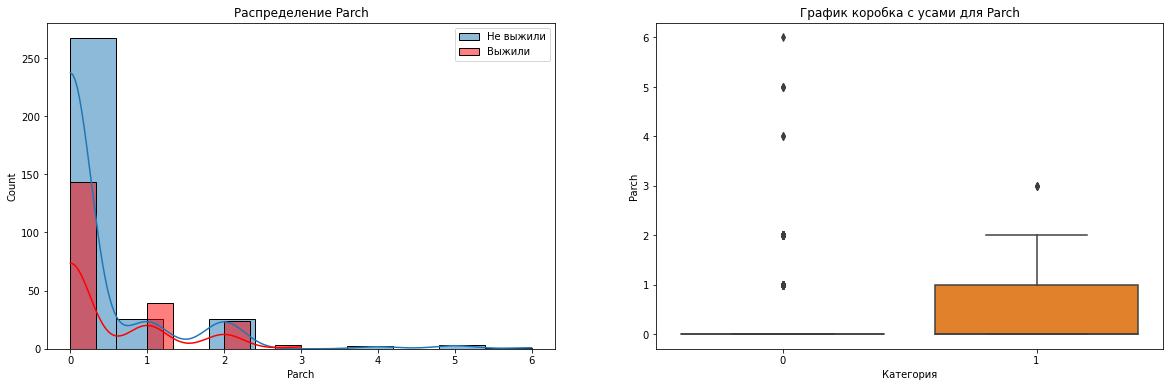

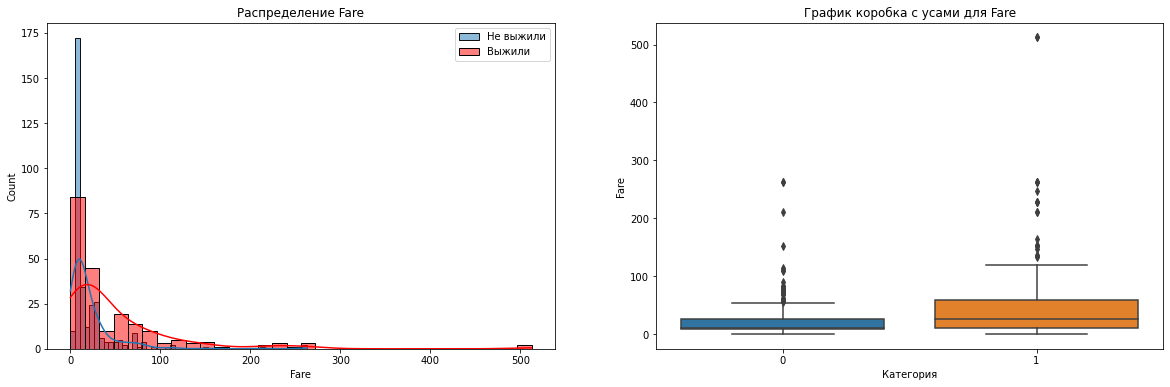

In [6]:
def describe_num_col(df, col):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    
    plot10 = sns.histplot(df[df['Survived']==0][col],ax=ax1, label='Не выжили', kde=True)
    sns.histplot(df[df['Survived']==1][col], ax=ax1, color='red', label='Выжили', kde=True)
    plot10.axes.legend()
    ax1.set_title('Распределение {name}'.format(name=col))
    
    sns.boxplot(x='Survived', y=col, data=df, ax=ax2)
    ax2.set_xlabel('Категория') 
    ax2.set_title('График коробка с усами для {name}'.format(name=col))

def describe_cat_col(df, col):
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.barplot(x=col, y='Survived', data=df)
    plt.show()

for col in cat_cols:
    describe_cat_col(train_df, col)
    
for col in num_cols:
    describe_num_col(train_df, col)

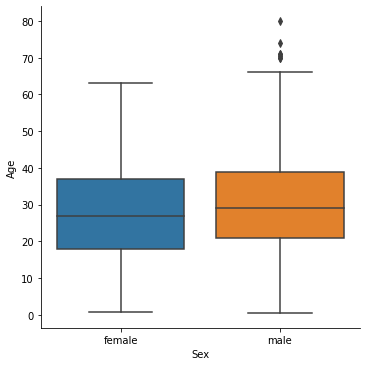

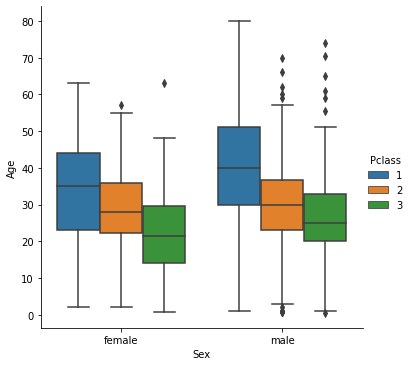

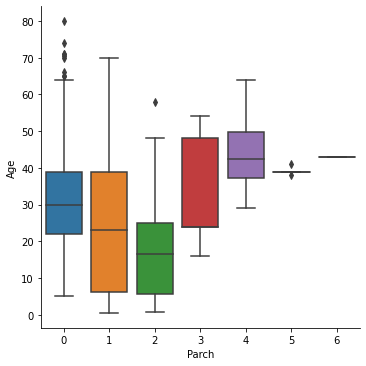

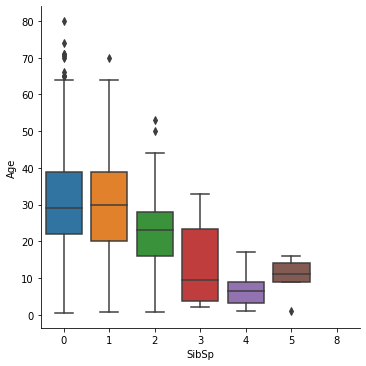

In [7]:
sns.catplot(y="Age",x="Sex",data=combined_df,kind="box")
sns.catplot(y="Age",x="Sex",hue="Pclass", data=combined_df,kind="box")
sns.catplot(y="Age",x="Parch", data=combined_df,kind="box")
sns.catplot(y="Age",x="SibSp", data=combined_df,kind="box")

## (#5) Заполнение пропущенных значений

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     534 non-null    float64
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 83.7+ KB


- Отсутствующие значения в "Survived" заполнять не нужно. Их необходимо предсказать.
- Необходимо заполнить "Age", "Cabin" и "Embarked"

In [9]:
combined_df["Age"] = combined_df.groupby(['Pclass', "Sex"])['Age'].apply(lambda x: x.fillna(x.median()))

In [10]:
combined_df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in combined_df['Cabin']])

In [11]:
combined_df["Embarked"] = combined_df["Embarked"].fillna("S")

## (#6) Добавление новых признаков и преобразование

In [12]:
titles = [i.split(",")[1].split(".")[0].strip() for i in combined_df["Name"]]
combined_df["Title"] = pd.Series(titles)
combined_df["Title"].head()

combined_df["Title"] = combined_df["Title"].replace(['Lady', 'the Countess', 'Countess', 'Capt', 
                                                     'Col','Don', 'Dr', 'Major', 
                                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combined_df["Title"] = combined_df["Title"].map({"Master": 0, "Miss": 1, "Ms" : 1 , "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})

In [13]:
combined_df["Fsize"] = combined_df["SibSp"] + combined_df["Parch"] + 1

In [ ]:
combined_df.info()

In [15]:
params=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Cabin', 'Fsize']

combined_df = combined_df[params]

In [16]:
encoder = preprocessing.LabelEncoder()

combined_df['Cabin'] = encoder.fit_transform(combined_df['Cabin'])
combined_df['Sex'] = encoder.fit_transform(combined_df['Sex'])


combined_df = pd.get_dummies(data=combined_df, columns=['Embarked','Title'], drop_first=True)

<ipython-input-16-a6cf932ae9f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Cabin'] = encoder.fit_transform(combined_df['Cabin'])
<ipython-input-16-a6cf932ae9f2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Sex'] = encoder.fit_transform(combined_df['Sex'])


## (#7) Построение моделей

In [17]:
models = [LinearDiscriminantAnalysis(),
         GradientBoostingClassifier(),
         RandomForestClassifier(),
         DecisionTreeClassifier(),
         KNeighborsClassifier(),
         LogisticRegression(),
         GaussianNB(),
         ]


combined_df = StandardScaler().fit_transform(combined_df)

x_train = combined_df[:train_len]
x_test = combined_df[train_len:]


for model in models:
    results = cross_validate(model, x_train, y_train, cv=10)
    accuracy = results['test_score'].mean()
    m=str(model)
    print(f"Accuracy for {str(model)} : {accuracy}")

Accuracy for LinearDiscriminantAnalysis() : 0.8200559049615654
Accuracy for GradientBoostingClassifier() : 0.7881201956673655
Accuracy for RandomForestClassifier() : 0.7772536687631029
Accuracy for DecisionTreeClassifier() : 0.7453878406708595
Accuracy for KNeighborsClassifier() : 0.7808525506638714
Accuracy for LogisticRegression() : 0.8239343116701608
Accuracy for GaussianNB() : 0.7603773584905661


In [18]:
params = {'penalty':['l1','l2'],
          'C' : [0.01,0.1,1,10,50,100,200,300],
          'solver':['liblinear', 'saga'],
          'max_iter' : np.arange(10, 20),
          }

grid_search = GridSearchCV(LogisticRegression(), param_grid=params, scoring="accuracy")
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(f"Лучшая точность {grid_search.best_score_}")
y_pred = grid_search.predict_proba(x_test)[:, 1]

create_submission(y_pred, "logistic-regression")

{'C': 50, 'max_iter': 15, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая точность 0.8183741844471873


In [19]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print(lr.get_params())
print("Точность:", lr.score(x_train, y_train))
y_pred = lr.predict_proba(x_test)[:, 1]
create_submission(y_pred, "logistic-regression1")

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Точность: 0.8258426966292135


In [28]:
params = {'max_features': [1, 2, 3, 5, 10],
          'min_samples_split': [2, 3, 5, 7, 10],
          'min_samples_leaf': [1, 3, 5, 7, 10],
          'bootstrap': [False],
          'n_estimators' :[100,200,300]
          }

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring="accuracy", n_jobs=1)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(f"Лучшая точность {grid_search.best_score_}")
y_pred = grid_search.predict_proba(x_test)[:, 1]

create_submission(y_pred, "random-forest")

In [24]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
print(gaussian.get_params())
print("Точность:", gaussian.score(x_train, y_train))
y_pred = gaussian.predict_proba(x_test)[:, 1]
create_submission(y_pred, "gaussian")

{'priors': None, 'var_smoothing': 1e-09}
Точность: 0.7752808988764045


In [25]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
print(lda.get_params())
print("Точность:", lda.score(x_train, y_train))
y_pred = lda.predict_proba(x_test)[:, 1]
create_submission(y_pred, "linear-discriminant-analysis")

{'covariance_estimator': None, 'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}
Точность: 0.8277153558052435


In [27]:
params = {'n_neighbors': [1,2,3,5,7,10,14,15]}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=params, scoring="accuracy", n_jobs=1)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(f"Лучшая точность {grid_search.best_score_}")
y_pred = grid_search.predict_proba(x_test)[:, 1]
create_submission(y_pred, "kneighbours")

{'n_neighbors': 10}
Лучшая точность 0.8014812202433432
